In [1]:
# Advanced model: XGBoost classifier for Late_delivery_risk

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
)

from xgboost import XGBClassifier

# Reproducibility / basic hyperparams
RANDOM_SEED = 42

BASE_DIR = "/mnt/c/Users/Home/Documents/PBA_Assignment"
csv_path = os.path.join(BASE_DIR, "data_model_preprocessing-PBA.csv")

print("CSV path:", csv_path)


CSV path: /mnt/c/Users/Home/Documents/PBA_Assignment/data_model_preprocessing-PBA.csv


In [2]:
# Cell 2: Seed + load dataframe

def set_seed(seed: int = RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)

set_seed()

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}")

df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:")
for c in df.columns:
    print(" -", c)

df.head()


Shape: (122557, 31)
Columns:
 - WeekendOrder
 - Processing.Days
 - Distance_km
 - `Order Item Product Price`
 - `Order Item Quantity`
 - `Order Item Discount Rate`
 - `Order Region`Caribbean
 - `Order Region`Central Africa
 - `Order Region`Central America
 - `Order Region`East Africa
 - `Order Region`East of USA
 - `Order Region`Eastern Asia
 - `Order Region`Eastern Europe
 - `Order Region`North Africa
 - `Order Region`Northern Europe
 - `Order Region`Oceania
 - `Order Region`South America
 - `Order Region`South Asia
 - `Order Region`South of  USA
 - `Order Region`Southeast Asia
 - `Order Region`Southern Africa
 - `Order Region`Southern Europe
 - `Order Region`US Center
 - `Order Region`West Africa
 - `Order Region`West Asia
 - `Order Region`West of USA
 - `Order Region`Western Europe
 - `Shipping Mode`Same Day
 - `Shipping Mode`Second Class
 - `Shipping Mode`Standard Class
 - Late_delivery_risk


,WeekendOrder,Processing.Days,Distance_km,`Order Item Product Price`,`Order Item Quantity`,`Order Item Discount Rate`,`Order Region`Caribbean,`Order Region`Central Africa,`Order Region`Central America,`Order Region`East Africa,...,`Order Region`Southern Europe,`Order Region`US Center,`Order Region`West Africa,`Order Region`West Asia,`Order Region`West of USA,`Order Region`Western Europe,`Shipping Mode`Same Day,`Shipping Mode`Second Class,`Shipping Mode`Standard Class,Late_delivery_risk
0,0,3.0,18500.760815,327.75,1,0.04,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,3.0,11640.755465,327.75,1,0.07,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,2.0,16576.993966,327.75,1,0.09,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,6.0,15192.036863,327.75,1,0.10,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2.0,15431.281031,327.75,1,0.12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
# Cell 3: Define target and features

TARGET_COL = "Late_delivery_risk"

if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not in dataframe.")

print("Target distribution:")
print(df[TARGET_COL].value_counts(normalize=True))

# Exclude obvious ID columns if present
ID_CANDIDATES = ["OrderId", "Order Id", "order_id"]
id_cols = [c for c in ID_CANDIDATES if c in df.columns]

exclude_cols = [TARGET_COL] + id_cols
feature_cols = [c for c in df.columns if c not in exclude_cols]

print("\nID columns excluded:", id_cols)
print("Number of features:", len(feature_cols))
print("First 10 features:", feature_cols[:10])

# Build X and y
X = df[feature_cols].copy()
X = X.apply(pd.to_numeric, errors="coerce")

# Handle any remaining NaNs (XGBoost can handle some, but this is safer/reproducible)
if X.isna().any().any():
    X = X.fillna(X.mean())

X = X.values.astype(np.float32)
y = df[TARGET_COL].astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape)


Target distribution:
Late_delivery_risk
1    0.54861
0    0.45139
Name: proportion, dtype: float64

ID columns excluded: []
Number of features: 30
First 10 features: ['WeekendOrder', 'Processing.Days', 'Distance_km', '`Order Item Product Price`', '`Order Item Quantity`', '`Order Item Discount Rate`', '`Order Region`Caribbean', '`Order Region`Central Africa', '`Order Region`Central America', '`Order Region`East Africa']
X shape: (122557, 30)
y shape: (122557,)


In [4]:
# Cell 4: Train / validation / test split (60 / 20 / 20)

n_samples = X.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)

train_end = int(0.6 * n_samples)
val_end = int(0.8 * n_samples)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train size:", X_train.shape[0])
print("Val size  :", X_val.shape[0])
print("Test size :", X_test.shape[0])

print("\nTrain class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))


Train size: 73534
Val size  : 24511
Test size : 24512

Train class distribution:
1    0.546876
0    0.453124
Name: proportion, dtype: float64


In [5]:
# Cell 5: Classification metrics helper (same style as baseline)

def compute_classification_metrics(y_true, logits_or_proba, threshold=0.5):
    """
    logits_or_proba: array of probabilities for class 1 (late).
    """
    probs = np.asarray(logits_or_proba).flatten()
    y_pred = (probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = np.nan

    cm = confusion_matrix(y_true, y_pred)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm,
    }


In [7]:
# Cell 6: Define and train XGBoost classifier (no early_stopping_rounds)

xgb_model = XGBClassifier(
    n_estimators=300,           # slightly fewer trees to reduce overfitting
    max_depth=6,               # tree depth
    learning_rate=0.05,        # shrinkage
    subsample=0.8,             # row sampling
    colsample_bytree=0.8,      # feature sampling per tree
    gamma=0.0,                 # min loss reduction for split
    reg_lambda=1.0,            # L2 regularisation
    objective="binary:logistic",
    eval_metric="logloss",     # evaluation metric for training
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

eval_set = [(X_train, y_train), (X_val, y_val)]

xgb_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

print("Model trained. n_estimators used:", xgb_model.get_params()["n_estimators"])


Model trained. n_estimators used: 300


In [8]:
# Cell 7: Evaluate XGBoost classifier

# Train metrics
train_proba = xgb_model.predict_proba(X_train)[:, 1]
train_metrics = compute_classification_metrics(y_train, train_proba)

# Validation metrics
val_proba = xgb_model.predict_proba(X_val)[:, 1]
val_metrics = compute_classification_metrics(y_val, val_proba)

# Test metrics
test_proba = xgb_model.predict_proba(X_test)[:, 1]
test_metrics = compute_classification_metrics(y_test, test_proba)

print("Train metrics:", train_metrics)
print("\nVal metrics:", val_metrics)
print("\nTest metrics:", test_metrics)


Train metrics: {'accuracy': 0.9627791225827509, 'precision': 0.9520420717439028, 'recall': 0.981374645645795, 'f1': 0.9664858510781589, 'roc_auc': 0.9904747121656641, 'confusion_matrix': array([[31332,  1988],
       [  749, 39465]])}

Val metrics: {'accuracy': 0.9552853820733548, 'precision': 0.9454766328426468, 'recall': 0.9754497198466529, 'f1': 0.9602293344945206, 'roc_auc': 0.9798044393785268, 'confusion_matrix': array([[10184,   763],
       [  333, 13231]])}

Test metrics: {'accuracy': 0.9566742819843342, 'precision': 0.9480266011276565, 'recall': 0.9745133006390251, 'f1': 0.9610874981679614, 'roc_auc': 0.9816005415853538, 'confusion_matrix': array([[10335,   719],
       [  343, 13115]])}


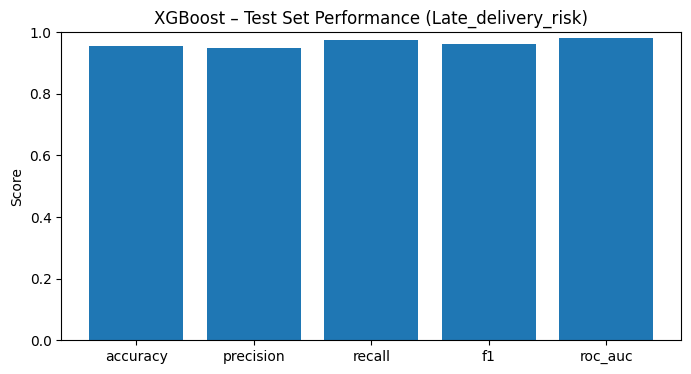

In [9]:
# Cell 8: Visualise XGBoost test-set performance

metrics_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
values = [test_metrics[m] for m in metrics_names]

plt.figure(figsize=(8, 4))
plt.bar(metrics_names, values)
plt.ylim(0, 1)
plt.title("XGBoost – Test Set Performance (Late_delivery_risk)")
plt.ylabel("Score")
plt.show()


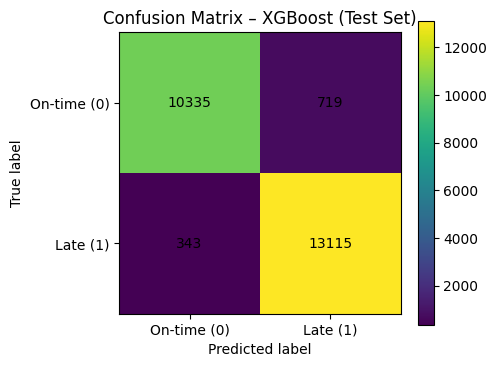

In [10]:
# Cell 9: Confusion matrix for XGBoost (test set)

cm = test_metrics["confusion_matrix"]

classes = ["On-time (0)", "Late (1)"]

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest")
plt.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – XGBoost (Test Set)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()


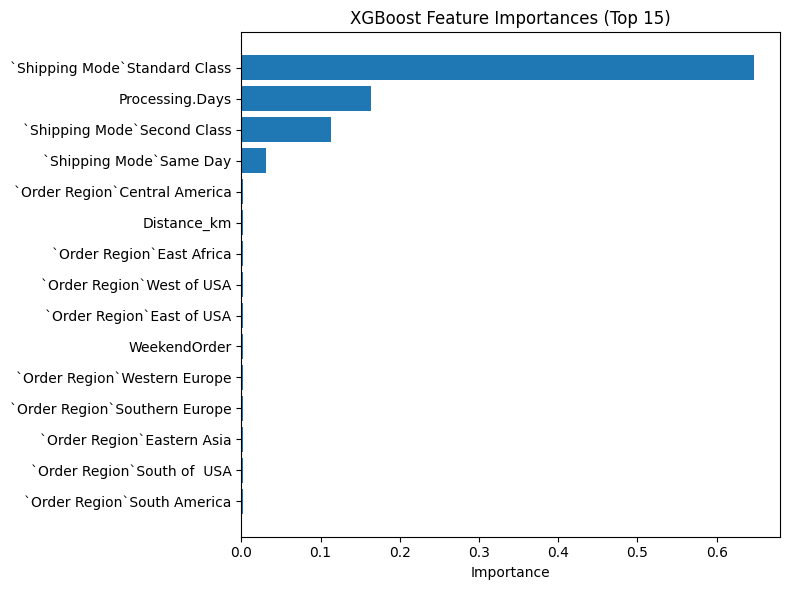

,feature,importance
29,`Shipping Mode`Standard Class,0.647602
1,Processing.Days,0.164169
28,`Shipping Mode`Second Class,0.113198
27,`Shipping Mode`Same Day,0.030654
8,`Order Region`Central America,0.002087
2,Distance_km,0.002072
9,`Order Region`East Africa,0.002006
25,`Order Region`West of USA,0.001985
10,`Order Region`East of USA,0.001920
0,WeekendOrder,0.001879


In [11]:
# Cell 10: Feature importances (gain-based) for XGBoost

importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

top_n = 15
top_fi = fi_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_fi["feature"], top_fi["importance"])
plt.gca().invert_yaxis()
plt.title(f"XGBoost Feature Importances (Top {top_n})")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

top_fi
